---
R Notebook  
Parts of code taken from Tim Churches blog on "Analysing COVID-19 (2019-nCoV) outbreak data with R"
https://timchurches.github.io/blog/posts/2020-02-18-analysing-covid-19-2019-ncov-outbreak-data-with-r-part-1/ 
Data taken from: https://github.com/covid19india/api
  
In this notebook, I will try to fit the SEIR(Susceptible,  Exposed, Infected,  Recovered) model to Maharashtra Covid-19 data.
In a closed population (that is, assuming no births or deaths), the SEIR model is:

\begin{aligned}
\frac{dS}{dt} & = -\frac{\beta IS}{N}\\
\\
\frac{dE}{dt} & = \frac{\beta IS}{N} - \kappa E\\
\\
\frac{dI}{dt} & = \kappa E - \gamma I\\
\\
\frac{dR}{dt} & = \gamma I
\end{aligned}


Load the needed packages

In [1]:
library(ggplot2)
library(jsonlite)
library(deSolve)
library(tidyverse)
require(lubridate)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'deSolve' was built under R version 3.6.3"Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filt

Get the states data from covid19india.org

In [2]:
states_daily = fromJSON("https://api.covid19india.org/states_daily.json")
dat = states_daily$states_daily

Have a look at the data.

In [3]:
dat

an,ap,ar,as,br,ch,ct,date,dd,dl,...,rj,sk,status,tg,tn,tr,tt,up,ut,wb
0,1,0,0,0,0,0,14-Mar-20,0,7,...,3,0,Confirmed,1,1,0,81,12,0,0
0,0,0,0,0,0,0,14-Mar-20,0,1,...,1,0,Recovered,0,0,0,9,4,0,0
0,0,0,0,0,0,0,14-Mar-20,0,1,...,0,0,Deceased,0,0,0,2,0,0,0
0,0,0,0,0,0,0,15-Mar-20,0,0,...,1,0,Confirmed,2,0,0,27,1,0,0
0,0,0,0,0,0,0,15-Mar-20,0,1,...,2,0,Recovered,1,0,0,4,0,0,0
0,0,0,0,0,0,0,15-Mar-20,0,0,...,0,0,Deceased,0,0,0,0,0,0,0
0,0,0,0,0,0,0,16-Mar-20,0,0,...,0,0,Confirmed,1,0,0,15,0,1,0
0,0,0,0,0,0,0,16-Mar-20,0,0,...,0,0,Recovered,0,1,0,1,0,0,0
0,0,0,0,0,0,0,16-Mar-20,0,0,...,0,0,Deceased,0,0,0,0,0,0,0
0,0,0,0,0,0,0,17-Mar-20,0,1,...,0,0,Confirmed,1,0,0,11,2,0,1


Convert the date which is in string to date format, add a column for short representation of date

In [4]:
dat$date = dmy(dat$date)
dat$short_date = substr(dat$date, start = 6, stop = 10)

The dat DataFrame has all states data. Filter Maharashtra Data and get the daily Confirmed, Recovered, Deceased cases of Maharashtra along with dates. Put these data in new DataFrame mh_dat.

In [5]:
Confirmed <- dat %>% filter(status == "Confirmed") %>% pull(mh)
Confirmed <- as.numeric(Confirmed)
Recovered <- dat %>% filter(status == "Recovered") %>% pull(mh)
Recovered <- as.numeric(Recovered)
Deceased <- dat %>% filter(status == "Deceased") %>% pull(mh)
Deceased <- as.numeric(Deceased)
Date <- dat %>% filter(status == "Confirmed") %>% pull(date)
Short_date <- dat %>% filter(status == "Confirmed") %>% pull(short_date)

mh_dat <- data.frame("Confirmed" = Confirmed, "Recovered" = Recovered, "Deceased" = Deceased, 
                     "Date" = Date, "Short_date"=Short_date)

For SEIR model we need cumulative daily confirmed cases and not daily confirmed cases. Get the cumulative confirmed, Recovered and, Deceased cases and then subtract cumulative recovered and cumulative deceased cases from cumulative confirmed cases to get actual cumulative confirmed cases for each day.

In [6]:
mh_dat <- within(mh_dat, Cum_Confirmed <- cumsum(Confirmed))
mh_dat <- within(mh_dat, Cum_Recovered <- cumsum(Recovered))
mh_dat <- within(mh_dat, Cum_Deceased <- cumsum(Deceased))

mh_dat$Cum_Confirmed = mh_dat$Cum_Confirmed - (mh_dat$Cum_Recovered + mh_dat$Cum_Deceased)

Let's look at newly created mh_dat DataFrame containing Maharashtra Data

In [7]:
mh_dat

Confirmed,Recovered,Deceased,Date,Short_date,Cum_Confirmed,Cum_Recovered,Cum_Deceased
14,0,0,2020-03-14,03-14,14,0,0
18,0,0,2020-03-15,03-15,32,0,0
6,0,0,2020-03-16,03-16,38,0,0
3,0,1,2020-03-17,03-17,40,0,1
3,0,0,2020-03-18,03-18,43,0,1
4,0,0,2020-03-19,03-19,47,0,1
4,0,0,2020-03-20,03-20,51,0,1
12,0,0,2020-03-21,03-21,63,0,1
10,0,1,2020-03-22,03-22,72,0,2
23,0,0,2020-03-23,03-23,95,0,2


Before going ahead, let's plot and view cumulative confirmed, recovered, and deceased cases per day starting from 14th March.

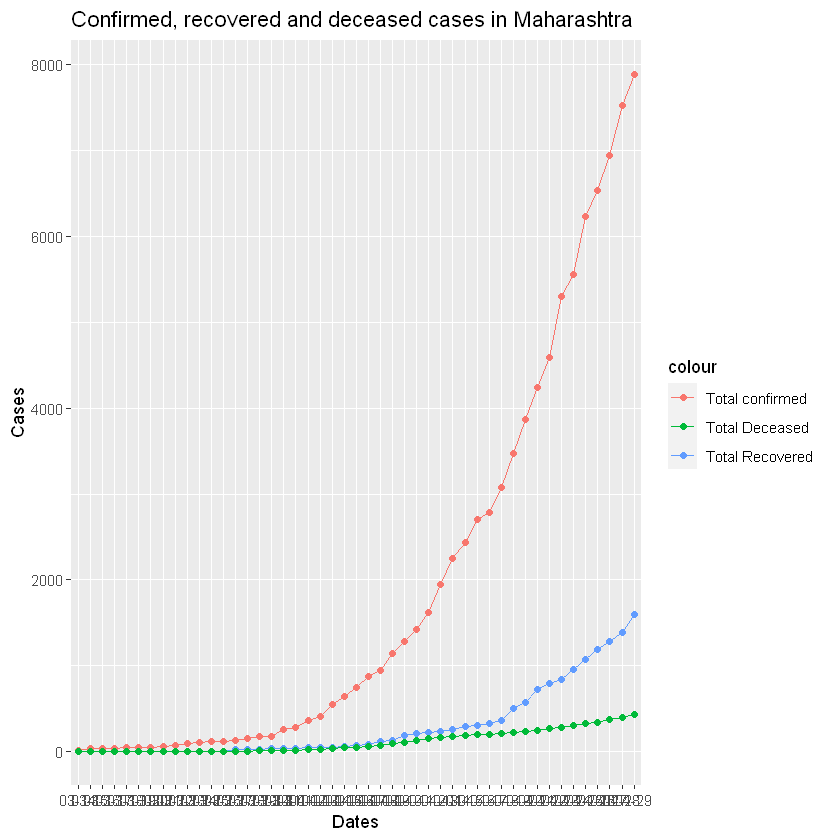

In [8]:
ggplot()+labs(title="Confirmed, recovered and deceased cases in Maharashtra", x="Dates", y="Cases")+
geom_point(mh_dat, mapping=aes(x = Short_date, y = Cum_Confirmed, group=1, color="Total confirmed")) +
geom_line(mh_dat, mapping=aes(x = Short_date, y = Cum_Confirmed, group=1, color="Total confirmed")) +
geom_point(mh_dat, mapping=aes(x = Short_date, y = Cum_Recovered, group=1, color="Total Recovered")) +
geom_line(mh_dat, mapping=aes(x = Short_date, y = Cum_Recovered, group=1, color="Total Recovered")) +
geom_point(mh_dat, mapping=aes(x = Short_date, y = Cum_Deceased, group=1, color="Total Deceased")) +
geom_line(mh_dat, mapping=aes(x = Short_date, y = Cum_Deceased, group=1, color="Total Deceased"))

Express the differential equations of SEIR model as an R function

In [9]:
SEIR <- function(time, state, parameters) {
  par <- as.list(c(state, parameters))
  with(par, {
    dS <- -beta * I * S/N
    dE <- beta * I * S/N - kappa * E
    dI <- kappa * E - gamma * I
    dR <- gamma * I
    list(c(dS, dE, dI, dR))
  })
}

Get the cumulative infected/confirmed cases from 14th March 2020 till 5th April 2020.

In [10]:
Infected <- mh_dat %>% filter(Date >= dmy("14-Mar-20"), Date <= dmy("05-Apr-20")) %>% 
pull(Cum_Confirmed)

Create an incrementing Day vector the same length as Infected. Initialize N with a population of Maharashtra. Initially, everyone is in susceptible class, so initialize Susceptible with S = N - cumulative confirmed cases on 14th march(First day of data), Infected (I) with cumulative Infected cases on 14th March, Exposed (E) with 30, No one has recovered on 14th March so R = 0.

In [11]:
Day <- 1:(length(Infected))
N <- 114200000
init <- c(S = N - Infected[1], E=30, I = Infected[1], R = 0)

Define a function RSS(Residual Sum of Squares) which needs to be minimized for Infected and predicted Infected cases to get optimum value for parameters β, γ, κ of differential equations.

In [12]:
RSS <- function(parameters) {
  names(parameters) <- c("beta", "kappa", "gamma")
  out <- ode(y = init, times = Day, func = SEIR, parms = parameters)
  fit <- out[, 4]
  sum((Infected - fit)^2)
}

Fit the SEIR model to our data by finding the values for β, γ, κ that minimize the residual sum of squares between the observed cumulative infected cases and the predicted cumulative infected cases.

In [13]:
Opt <- optim(c(0.5, 0.5, 0.5), RSS, method = "L-BFGS-B", lower = c(0, 0, 0), upper = c(1, 1, 1))
Opt$message

[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Examine the fitted values for β, γ, κ.

In [14]:
Opt_par <- setNames(Opt$par, c("beta", "kappa", "gamma"))
Opt_par

beta     kappa     gamma 
1.0000000 0.2959163 0.4597164

Let's use this model to predict the cumulative infected cases until 25th April.

Joining, by = "Date"


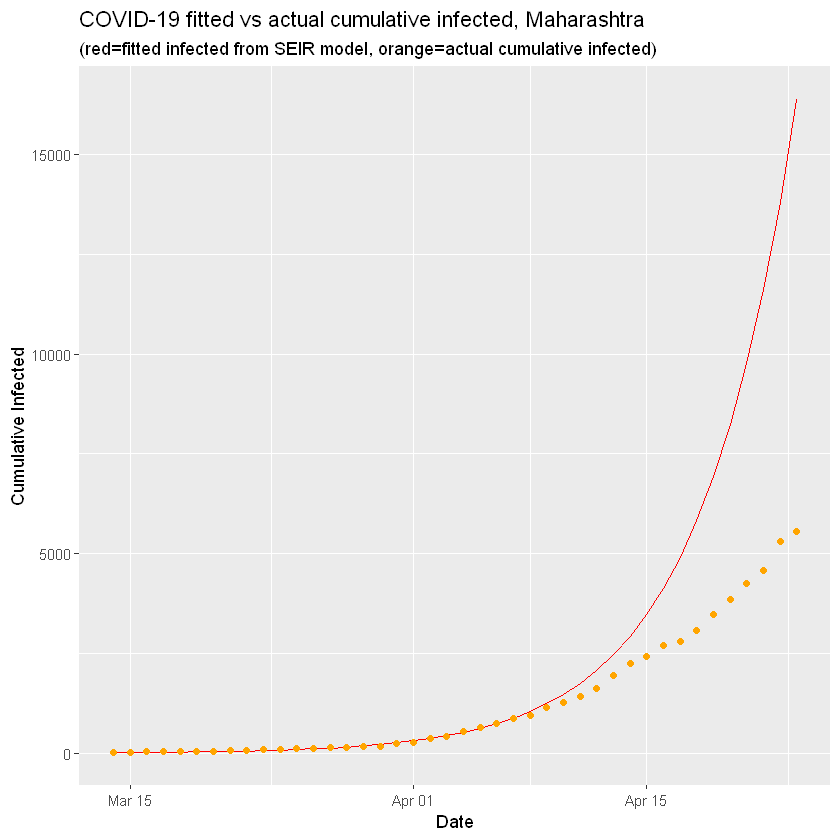

In [15]:
t <- 1:as.integer(dmy("25-Apr-20") - dmy("14-Mar-20"))
fitted_cumulative_incidence <- data.frame(ode(y = init, times = t, func = SEIR, parms = Opt_par))

fitted_cumulative_incidence <- fitted_cumulative_incidence %>% 
  mutate(Date = dmy("14-Mar-20") + days(t - 1)) %>% 
  left_join(mh_dat %>% ungroup() %>% select(Date, Cum_Confirmed))

fitted_cumulative_incidence %>% filter(Date <= dmy("25-Apr-2020")) %>% 
  ggplot(aes(x = Date)) + geom_line(aes(y = I), colour = "red") + 
  geom_point(aes(y = Cum_Confirmed), colour = "orange") + 
  labs(y = "Cumulative Infected", 
       title = "COVID-19 fitted vs actual cumulative infected, Maharashtra", 
       subtitle = "(red=fitted infected from SEIR model, orange=actual cumulative infected)")

We can see that the actual infected is much lower than that predicted by the SEIR model. The reason is that model is not taking into account the measures by the government like lockdown, quarantine. So, using this model we can say that measures taken by the government are in the right direction and working.
Let's see what will happen if the outbreak is left to run without any intervention.

Joining, by = "Date"
Warning message:
"Removed 103 rows containing missing values (geom_point)."

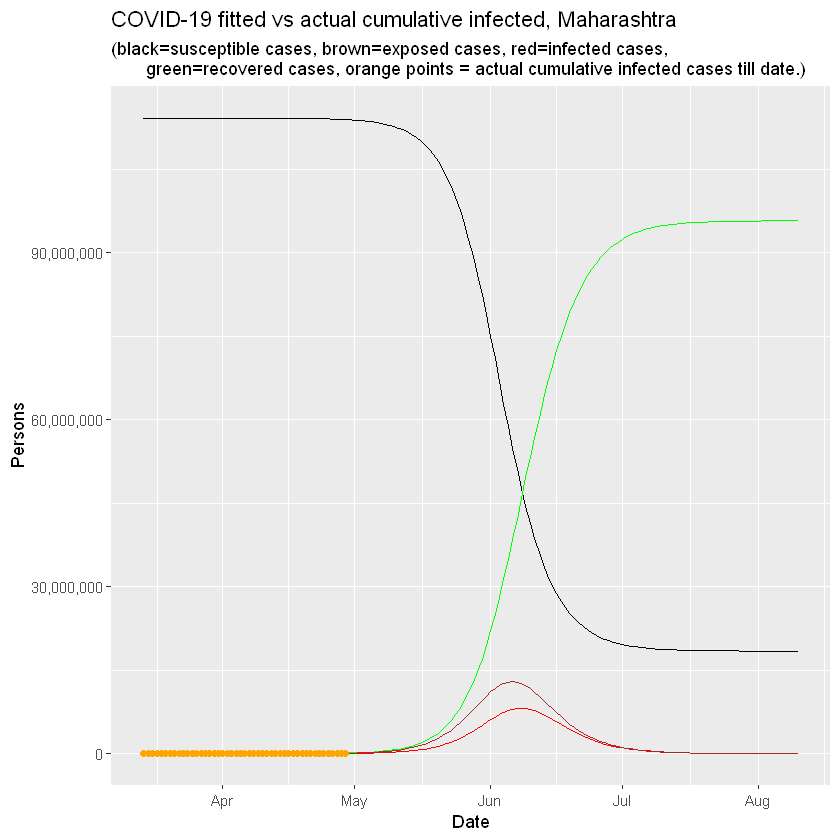

In [16]:
t <- 1:150
fitted_cumulative_incidence <- data.frame(ode(y = init, times = t, 
                                              func = SEIR, parms = Opt_par))

fitted_cumulative_incidence <- fitted_cumulative_incidence %>% 
  mutate(Date = dmy("14-Mar-20") + days(t - 1)) %>% 
  left_join(mh_dat %>% ungroup() %>% select(Date, Cum_Confirmed))

fitted_cumulative_incidence %>% ggplot(aes(x = Date)) + 
  geom_line(aes(y = I), colour = "red") + 
  geom_line(aes(y = S), colour = "black") + 
  geom_line(aes(y = R), colour = "green") + 
  geom_line(aes(y = E), colour = "brown") + 
  geom_point(aes(y = Cum_Confirmed), colour = "orange") + 
  scale_y_continuous(labels = scales::comma) + 
  labs(y = "Persons", title = "COVID-19 fitted vs actual cumulative infected, Maharashtra",
       subtitle = "(black=susceptible cases, brown=exposed cases, red=infected cases, 
       green=recovered cases, orange points = actual cumulative infected cases till date.)")

Clearly this is a disaster with about 5-6 million infected cases reaching a peak somewhere around mid June.